In [1]:
import numpy as np

In [2]:
a = np.array([[0,1,2,3,4,5,6,7,8,9],[0,1,2,3,4,5,6,7,8,9],[0,1,2,3,4,5,6,7,8,9],[0,1,2,3,4,5,6,7,8,9]])

In [3]:
a[::2,0:10:3]

array([[0, 3, 6, 9],
       [0, 3, 6, 9]])

In [4]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """

    Parameters
    ----------
    input_data : (データ数, チャンネル, 高さ, 幅)の4次元配列からなる入力データ
    filter_h : フィルターの高さ
    filter_w : フィルターの幅
    stride : ストライド
    pad : パディング

    Returns
    -------
    col : 2次元配列
    """
    N, C, H, W = input_data.shape
    #切り捨て除算
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    print(f'{filter_w}')
    #第一引数：N次元の行列　第二引数：前後の文字詰める量　第三引数：埋め込み方式
    #データ数、チャンネル方向にはパディング０、高さと幅の方向には前後にpad分0パディングする
    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            #https://qiita.com/MA-fn/items/45a45a7417dfb37a5248
            #フィルターの要素ごとに乗算する値を取得し、行に並べたい
            #⇒フィルターに応じてとびとびに値を取得する
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
            
    #N⇔N C⇔oh fh⇔ow fw⇔C oh⇔fh ow⇔fw →　N*oh*ow*C*fh*fw →(N*oh*ow)*(C*fh*fw)
    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

In [5]:
import sys, os
sys.path.append(os.pardir)
from common.util import im2col
x1 = np.random.rand(1, 3, 7, 7)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape) # (9, 75)
x2 = np.random.rand(10, 3, 7, 7) # 10 個のデータ
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape) # (90, 75)

(9, 75)
(90, 75)


畳み込み層の実装

In [6]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
    
    def forward(self, x):
        #フィルターの個数、フィルターのチャンネル数（奥行）、フィルターの高さ、フィルターの幅
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2*self.pad - FW) / self.stride)
        
        #(N, C, H, W) → (N*oh*ow,C*FH*FW)
        col = im2col(x, FH, FW, self.stride, self.pad)
        #フィルター（C*FH*FW）を１列に展開　行＝C*FH*FW
        #フィルター枚数が列数FNとなる
        col_W = self.W.reshape(FN, -1).T 
        #(N*oh*ow,FN)
        out = np.dot(col, col_W) + self.b
        #(N*oh*ow,FN)⇒(N,out_h,out_w,C)⇒(N,C,out_h,out_w)番号に対応する軸が入る
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        
        return out

Pooling層の実装

In [7]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        #展開(1)
        #(N, C, H, W) → (N*oh*ow,C*pool_h*pool_w)
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        #(N*oh*ow,C*pool_h*pool_w)⇒(N*oh*ow*C,pool_h*pool_w)
        #プーリング適用領域の幅*高さの長さを列に持つ行列
        col = col.reshape(-1, self.pool_h*self.pool_w)
        
        #最大値 各々のプーリング適用領域に対して最大値を取得する
        out = np.max(col, axis=1)
        
        #整形　取得した最大値(N*oh*ow*C,1)⇒(N,oh,ow,C)⇒(N,C,oh,ow)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        
        return out
    

単純なCNNの実装

In [8]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient

# 単純なConvNet
# conv - relu - pool - affine - relu - affine - softmax
class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28),\
                 conv_param={'filter_num':30, 'filter_size':5,\
                            'pad':0, 'stride':1},\
                hidden_size=100, output_size=10, weight_init_std=0.01):
        #=================================================================================
        #input_dim = 入力データの（チャンネル、高さ、幅）の次元
        #conv_param = 畳み込み層のハイパーパラメータ
        #filter_num = フィルターの数　filter_size = フィルターのサイズ pad = パディング stride = ストライド
        #hidden_size = 隠れ層（全結合）のニューロンの数
        #output_size = 出力層（全結合）のニューロンの数
        #weight_init_std = 初期化の際の重みの標準偏差
        #==================================================================================
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        #プーリング層の出力サイズを計算
        #プーリング適用領域が2*2で、maxプーリングを行うと畳み込み層の出力数の1/4になる
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))
        
        #重みパラメータの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)
        
        #レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'],self.params['b1'],conv_param['stride'],conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'],self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'],self.params['b3'])
        self.last_layer = SoftmaxWithLoss()
        
    #推論
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    
    #損失関数の値を求める
    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)
    
    def accuracy(self, x, t, batch_size=100):
        #one-hot表現をラベル表現に直す
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]
    
    def numerical_gradient(self, x, t):
        """勾配を求める（数値微分）
        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル
        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads
    
    #誤差逆伝搬法を用いた勾配を求める
    def gradient(self, x, t):
        #forwardで推論を行った後
        # forward
        self.loss(x, t)
        
        # backwardで誤差逆伝搬、勾配を求める
        dout = 1
        dout = self.last_layer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
            
        # 設定
        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affine1'].dW
        grads['b2'] = self.layers['Affine1'].db
        grads['W3'] = self.layers['Affine2'].dW
        grads['b3'] = self.layers['Affine2'].db
        return grads
    
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

MNISTのデータを用いたCNNの分類実験

In [9]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
#from simple_convnet import SimpleConvNet
from common.trainer import Trainer
from collections import OrderedDict

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 処理に時間のかかる場合はデータを削減 
x_train, t_train = x_train[:5000], t_train[:5000]
x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20
#単純なCNNの設定
network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

#ハイパーパラメータの最適化          
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# パラメータの保存
network.save_params("params.pkl")
print("Saved Network Parameters!")

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

train loss:2.299566186193197
=== epoch:1, train acc:0.385, test acc:0.349 ===
train loss:2.2966349281075766
train loss:2.292183985096533
train loss:2.286814383440778
train loss:2.2819420196161637
train loss:2.2679352687314545
train loss:2.2458468782144316
train loss:2.2279796652495145
train loss:2.205772341130686
train loss:2.1904901821161915
train loss:2.136951992375044
train loss:2.1008377885148453
train loss:2.044308900570155
train loss:1.9259422374524666
train loss:1.966730634508688
train loss:1.926506821305788
train loss:1.810888977102704
train loss:1.7212297759218596
train loss:1.7180235640307167
train loss:1.5993995871768456
train loss:1.5654615720456622
train loss:1.4177915575492441
train loss:1.3768212271015343
train loss:1.2306687471370241
train loss:1.172596997650912
train loss:1.1139450083768654
train loss:0.9460925686864372
train loss:0.9816454145476718
train loss:0.8437136245780463
train loss:0.7303004987611239
train loss:0.8973182969540281
train loss:0.7908609300948933
t

<Figure size 640x480 with 1 Axes>

畳み込みにおける重みの可視化

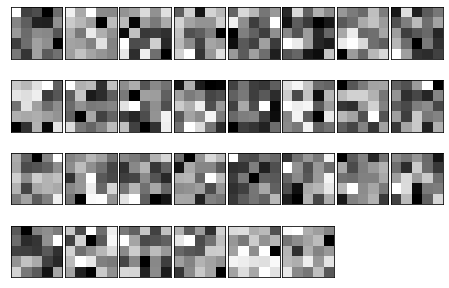

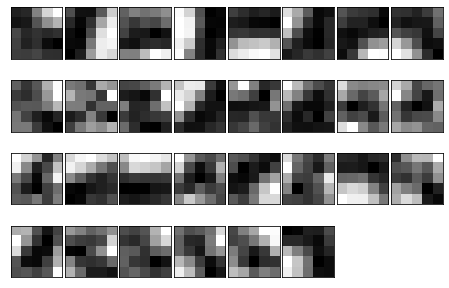

In [11]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
#from simple_convnet import SimpleConvNet

def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# ランダム初期化後の重み
filter_show(network.params['W1'])

# 学習後の重み
network.load_params("params.pkl")
filter_show(network.params['W1'])